In [1]:
# Import libraries

# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

AxesSubplot(0.125,0.125;0.775x0.755)


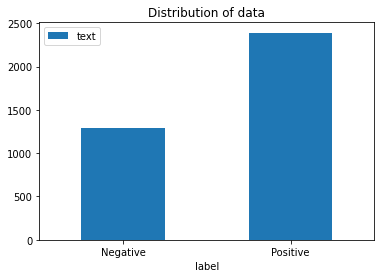

In [2]:
dataset = pd.read_csv('sentiment-data-v2.csv')

# Removing the unnecessary columns.
dataset = dataset[['label','text']]

# Plotting the distribution for dataset.
ax = dataset.groupby('label').count().plot(kind='bar', title='Distribution of data',
                                               legend=True)

ax.set_xticklabels(['Negative','Positive'], rotation=0)

print(ax)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['label'])

In [3]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in malay
stopwordlist = ['acap', 'acap kali','adakala','adakalanya','adalah','adapun','adoi','aduh','aduhai',
             'agak agaknya','agar','alamak','alhasil','alkisah','amat','amboi','andai','andai kata','aneka',
             'antara','apa','apabila','apakala', 'apa lagi','arkian',
             'atau', 'au','auh', 'ayuh','ayuhai','bagai', 'bagaimana', 'bagaimanapun',
            'bagi', 'bahawa', 'bahawasanya','bahkan', 'banyak', 'barangkali',
             'beberapa','belum','benar','berapa','betul','bila','bila mana','boleh','boleh jadi',
             'buat', 'bukan', 'dalam', 'dan', 'dapat','dari', 'darihal', 'daripada','demi','dengan', 'di',
             'ee', 'eh', 'ehem', 'enggan', 'entah', 'entahkan','gamaknya',
             'ha','haah','hanya','harapnya', 'harus','hatta','hei','helo', 'hendak', 'hingga',
            'ialah', 'jangan','jemput', 'jika','jikalau', 'jua','juga','kadang','kadangkala',
            'kelakian', 'kalau', 'ke', 'kemudian', 'kenapa', 'kendatipun' ,'kepada',
             'kerana', 'ketika', 'kian', 'lagi', 'lagikan', 'laksana', 'lalu', 'macam', 'maha',
             'mahu', 'mahupun', 'maka','malah','malahan','mana','manakala','mana lagi','masih', 'masing-masing', 
             'memang', 'mengapa','meskipun', 'mesti', 'minta',
             'misal', 'mungkin', 'nampaknya', 'namun', 'nan', 'nian', 'nun', 'oh', 'oleh', 'oleh itu',
             'pabila', 'pada', 'padahal', 'paling','para', 'pelbagai', 'perlu', 'pernah', 'pun',
             'sahaja', 'saja', 'sambil', 'sampai', 'sangat', 'sebab', 'sebagai',
             'sebagaimana', 'sebermula', 'sedang', 'sedikit', 'segala', 'sejak', 'sekali', 'sekali peristiwa', 
             'sekalian','sekiranya', 'selalu', 'seluruh', 'semasa', 'sementara', 'semoga', 'semua', 'seperti', 'serba',
             'serta', 'sesungguhnya', 'setelah', 'setiap', 'sewaktu','siapa', 'sila', 'sudah', 'sungguh', 'sungguhpun', 
             'supaya', 'syabas', 'syahadan', 'tatkala', 'telah', 'tentang',
             'terhadap','terlalu','tetapi', 'tiap-tiap', 'tidak', 'tolong', 'umpama','untuk', 'usah', 'wah', 'wahai',
             'walau','walaupun','yang']

In [4]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
                
        processedText.append(tweetwords)
        
    return processedText

In [5]:
import time
import nltk
nltk.download('wordnet')
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Text Preprocessing complete.
Time Taken: 4 seconds


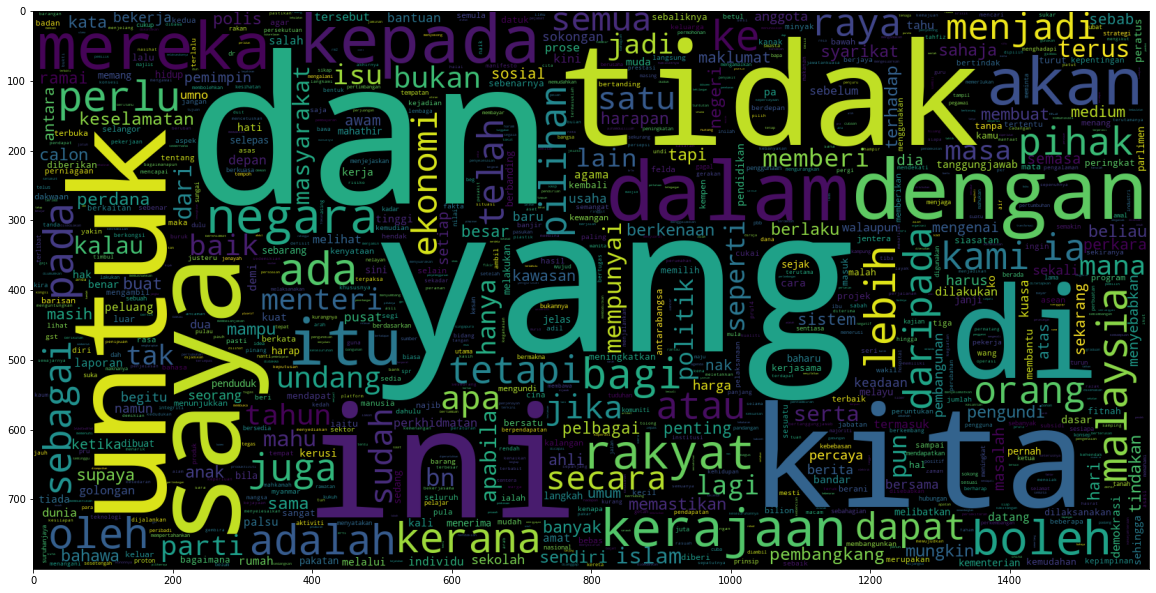

In [6]:
data_neg = processedtext[:1000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

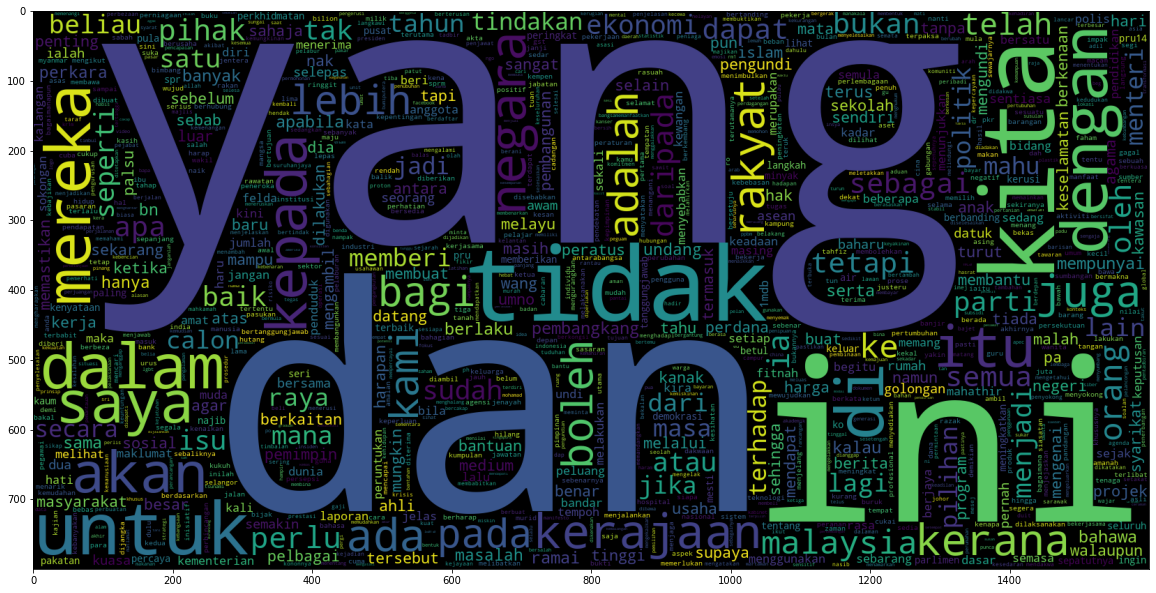

In [7]:
data_pos = processedtext[1000:]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

In [8]:
# Data split to test and training set

X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.2, random_state = 0)
print(f'Data Split done.')
print('Training size: 80%, Testing size: 20%')

Data Split done.
Training size: 80%, Testing size: 20%


In [9]:
# TF-IDF transformer

vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  40646


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [10]:
# Transform dataset into matrix of TF-IDF features
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [11]:
# MODEL EVALUATION - USE BERNOLLI NB, LINEAR SVC, Logistic Regression
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       267
    Positive       0.64      1.00      0.78       470

    accuracy                           0.64       737
   macro avg       0.32      0.50      0.39       737
weighted avg       0.41      0.64      0.50       737



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


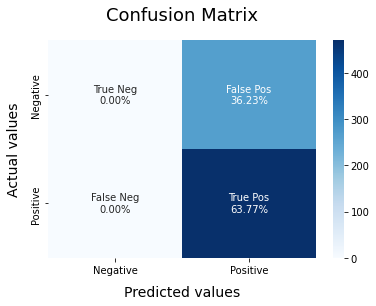

In [12]:
# Evaluate using Bermnoulli model
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

    Negative       0.70      0.48      0.57       267
    Positive       0.75      0.89      0.81       470

    accuracy                           0.74       737
   macro avg       0.73      0.68      0.69       737
weighted avg       0.73      0.74      0.72       737



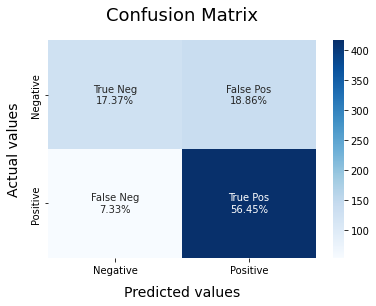

In [13]:
# Eval linear SVC model
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

    Negative       0.73      0.36      0.48       267
    Positive       0.72      0.93      0.81       470

    accuracy                           0.72       737
   macro avg       0.72      0.64      0.64       737
weighted avg       0.72      0.72      0.69       737



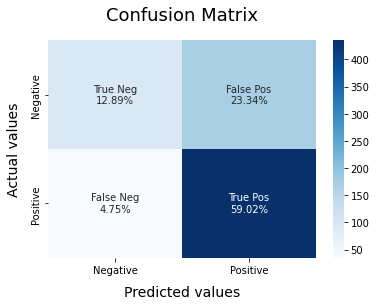

In [14]:
# Eval Logistic Regression model
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       267
    Positive       0.64      1.00      0.78       470

    accuracy                           0.64       737
   macro avg       0.32      0.50      0.39       737
weighted avg       0.41      0.64      0.50       737



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


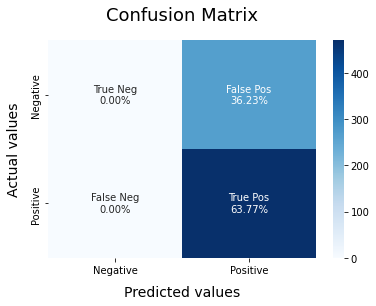

In [15]:
# Eval Random Forest model
RFmodel = RandomForestClassifier(max_depth=2, random_state=0)
RFmodel.fit(X_train, y_train)
model_Evaluate(RFmodel)

              precision    recall  f1-score   support

    Negative       0.56      0.48      0.52       267
    Positive       0.73      0.79      0.76       470

    accuracy                           0.68       737
   macro avg       0.65      0.63      0.64       737
weighted avg       0.67      0.68      0.67       737



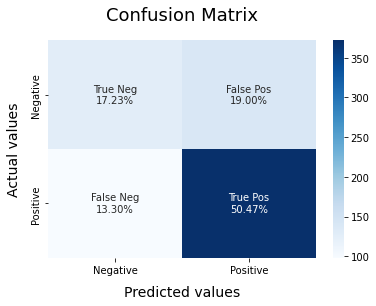

In [16]:
# Eval Decision Tree classifier model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

DTclf = DecisionTreeClassifier(random_state=0)
cross_val_score(DTclf, X_train, y_train, cv=10)

DTclf.fit(X_train, y_train)
model_Evaluate(DTclf)

In [17]:
# Save the model

file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-LinearSVC.pickle','wb')
pickle.dump(SVCmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

file = open('Sentiment-RandomForest.pickle','wb')
pickle.dump(RFmodel, file)
file.close()

file = open('Sentiment-DecisionTree.pickle','wb')
pickle.dump(DTclf, file)
file.close()

In [18]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    file = open('..path/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('..path/Sentiment-LinearSVC.pickle', 'rb')
    SVCmodel = pickle.load(file)
    file.close()
    
    return vectoriser, SVCmodel

In [23]:
def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','label'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["pelajar ni bagus",
            "Pelajar sekarang takde duit, kesian tengok dorang",
            "Politicians memang jahat buat rakyat macam ni",
            "Duit aku hilang weh, sape curi ni",
            "Okay la kita ada duit poket lagi, so takde masalah nak hidup",
            "Rakyat Sabah marah",
            "Jika calon-calon bermasalah dipilih, parti terpaksa berhadapan dengan pelbagai serangan",
            "saya harap politik kini makin baik dan mereka berubah"]
    
    df = predict(vectoriser, SVCmodel, text)
    print(df)

                                                text     label
0                                   pelajar ni bagus  Positive
1  Pelajar sekarang takde duit, kesian tengok dorang  Negative
2      Politicians memang jahat buat rakyat macam ni  Negative
3                  Duit aku hilang weh, sape curi ni  Negative
4  Okay la kita ada duit poket lagi, so takde mas...  Positive
5                                 Rakyat Sabah marah  Negative
6  Jika calon-calon bermasalah dipilih, parti ter...  Positive
7  saya harap politik kini makin baik dan mereka ...  Positive
